Import the relevant modules
Input the relevant parameters

In [1]:
import sys
import os
import os.path
import astropy.io.fits as pyfits
import numpy as np
import glob
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord

images=glob.glob('/archive/TraP_test_data/ELAIS-N1/L686976/ELIAS_L686976-*.fits')
deepImage = '/scratch/ideruiter/deep_fields_individual_epochs/L686976_image_full_ampphase_di_m.NS.app.restored.fits'
detectThresh = 6.
detectThreshDeep = 20.
radius = 900 # pixels
radiusDeep = 3600
grid = 50 # pixels
deblend = 0 # 0 = turned off
forceBeam = True
maxSep = 20  # * u.arcsec
minSNR = 20

Run PySE on all the images to obtain the csv files

In [67]:
for image in images:
    img = image.split('.')[0]+'.csv'
    img = img.split('/')[-1]
    if os.path.isfile(img):
        print(img)
    else:
        if forceBeam:
            os.system('pyse.py --detection '+str(detectThresh)+' --deblend-thresholds '+str(deblend)
                      +' --grid '+str(grid)+' --radius '+ str(radius)+' --force-beam --csv '+image)
        else:
            os.system('pyse.py --detection '+str(detectThresh)+' --deblend-thresholds --csv '+str(deblend)
                      +' --grid '+str(grid)+' --radius '+ str(radius)+image)

ELIAS_L686976-t0391-image-pb.csv
ELIAS_L686976-t1749-image-pb.csv
ELIAS_L686976-t1709-image-pb.csv
ELIAS_L686976-t1575-image-pb.csv
ELIAS_L686976-t0976-image-pb.csv
ELIAS_L686976-t0147-image-pb.csv
ELIAS_L686976-t1357-image-pb.csv
ELIAS_L686976-t0684-image-pb.csv
ELIAS_L686976-t0409-image-pb.csv
ELIAS_L686976-t1721-image-pb.csv
ELIAS_L686976-t0133-image-pb.csv
ELIAS_L686976-t0611-image-pb.csv
ELIAS_L686976-t1419-image-pb.csv
ELIAS_L686976-t0673-image-pb.csv
ELIAS_L686976-t0834-image-pb.csv
ELIAS_L686976-t0550-image-pb.csv
ELIAS_L686976-t1076-image-pb.csv
ELIAS_L686976-t1383-image-pb.csv
ELIAS_L686976-t0477-image-pb.csv
ELIAS_L686976-t1736-image-pb.csv
ELIAS_L686976-t0665-image-pb.csv
ELIAS_L686976-t0252-image-pb.csv
ELIAS_L686976-t0022-image-pb.csv
ELIAS_L686976-t1410-image-pb.csv
ELIAS_L686976-t0036-image-pb.csv
ELIAS_L686976-t1617-image-pb.csv
ELIAS_L686976-t1676-image-pb.csv
ELIAS_L686976-t0669-image-pb.csv
ELIAS_L686976-t1429-image-pb.csv
ELIAS_L686976-t0807-image-pb.csv
ELIAS_L686

Run PySE on the deep image to get the main source catalogue.
Use 20 sigma detection threshold so only brighter sources. Otherwise the same PySE settings.

In [68]:
img = deepImage.rstrip('.fits')+'.csv'
img = img.split('/')[-1]
if os.path.isfile(img):
    runcat =pd.read_csv(img, delimiter=', ', engine='python')
else:       
    if forceBeam:
        os.system('pyse.py --detection '+str(detectThreshDeep)+' --deblend-thresholds '+str(deblend)
                    +' --grid '+str(grid)+' --radius '+ str(radiusDeep)+' --force-beam --csv '+deepImage)
    else:
        os.system('pyse.py --detection '+str(detectThreshDeep)+' --deblend-thresholds --csv '+str(deblend)
                    +' --grid '+str(grid)+' --radius '+ str(radiusDeep)+deepImage)
    runcat =pd.read_csv(img, delimiter=', ', engine='python')
#print(runcat.columns.tolist())
runcat['SkyCoords'] = runcat.apply(lambda row: coord.SkyCoord(row.ra, row.dec, unit=(u.deg, u.deg), frame='fk5'), axis=1)
#print(runcat)
rct = coord.SkyCoord(runcat.ra, runcat.dec, unit=(u.deg, u.deg), frame='fk5')

Loop through all the images to determine the offset from the deep image position.
Use astropy source association?

In [69]:
if os.path.exists('separations.csv'):
    AllSeps = pd.read_csv('separations.csv')
    #AllSeps = np.genfromtxt('separations.csv', delimiter=',')
else:
    #AllSeps=[]
    AllSeps = pd.DataFrame(columns = ['img','ra_err','dec_err','sep','snr'])
    for image in images:
        img = image.split('.')[0]+'.csv'
        img = img.split('/')[-1]
        sources = pd.read_csv(img, delimiter=', ', engine='python')
        sources['SkyCoords'] = sources.apply(lambda row: coord.SkyCoord(row.ra, row.dec, unit=(u.deg, u.deg), frame='fk5'), axis=1)

        srcs = coord.SkyCoord(sources.ra, sources.dec, unit=(u.deg, u.deg), frame='fk5')

        idx, d2d, d3d = srcs.match_to_catalog_sky(rct)
        seps = np.array(d2d.arcsecond)     
        sources['sep']=seps
        sources['img']=img
        
        sources = sources.filter(['img','ra_err','dec_err','sep','snr'])
        #print(sources)
        sources = sources[sources.sep < maxSep]
        #print(len(sources))        
        AllSeps = pd.concat([AllSeps, sources])
    
    AllSeps.to_csv('separations.csv')
        


In [70]:
#print(AllSeps)

AllSeps = AllSeps[AllSeps.sep < maxSep]
AllSeps = AllSeps[AllSeps.snr > minSNR]
#print(AllSeps)


print(np.mean(AllSeps.sep))
print(np.median(AllSeps.sep))
print(np.std(AllSeps.sep))

print(np.mean(3600*AllSeps.ra_err))
print(np.median(3600*AllSeps.ra_err))
print(np.std(3600*AllSeps.ra_err))

#print(len(srcs),len(d2d))

4.611214289219901
4.409646717984895
2.5896110164625523
1.973922469264975
1.764
1.1176118105001263


The offsets being measured should be a combination of the fitting error and the systematic error. These are normally added in quadrature.
i.e. offset = sqrt ( ra_error^2 + dec_error^2 + systematic^2)
--> offset^2 / (ra_error^2 + dec_error^2 ) = systematic^2

Systematic is to solve source association problems for bright sources, therefore use a large SNR.

In [74]:
systematic = np.mean(AllSeps.sep)**2. / (np.mean(3600*AllSeps.ra_err)**2. + np.mean(3600*AllSeps.dec_err)**2.)
print(systematic**0.5)

systematic = np.median(AllSeps.sep)**2. / (np.median(3600*AllSeps.ra_err)**2. + np.median(3600*AllSeps.dec_err)**2.)
print(systematic**0.5)

2.0368749804375663
2.2211948594971407


In [72]:
from scipy import stats
ae, loce, scalee = stats.skewnorm.fit(AllSeps.sep)
print(ae, loce, scalee)

3.873919704688634 1.4747370938909725 4.067383912954343


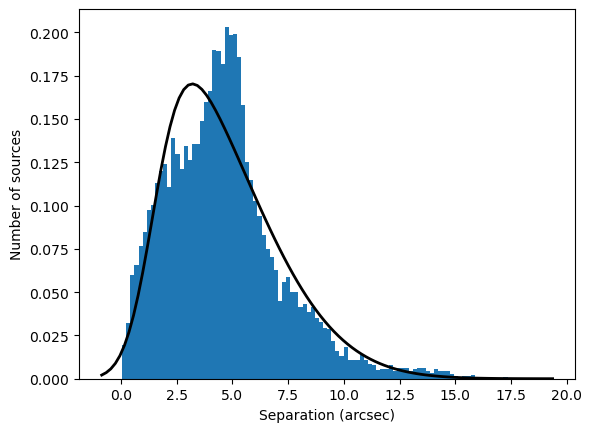

In [73]:
from matplotlib import pyplot as plt 
plt.hist(AllSeps.sep,bins=100, density=True,histtype='stepfilled')

plt.xlabel('Separation (arcsec)')
plt.ylabel('Number of sources')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.skewnorm.pdf(x,ae, loce, scalee)#.rvs(100)
plt.plot(x, p, 'k', linewidth=2)

plt.show()